# Learning To Search

This notebook is an attempt to explain (mostly to myself) how reinforcement learning for simple, turn-based, finite-state games work. While there is definitely no shortage of machine-learning related tutorials out there, there've always been certain questions that I felt didn't get the attention they deserved (or I was too slow understanding the answer). Note that a lot of the formalisms are probably more clearly defined in other ressources and possibly under different names. Ultimately, this might use some of the language from the reinforcement community, but the notebook stays self-contained.

This notebook tries to balance mathematical formulations and code snippets. Ultimately, every implementation related question (that comes to my mind) will be adressed and formulated mathematically, albeit with different degrees of care.

The game (that will be explained in the next section) is simple and has an optimal strategy which allows for a benchmark / reference solution.

## The game

The opponent picks a random integer from the set $\{0,...,n-1\}$. The player gets to make guesses and the opponent will inform the player whether the number guessed was i) too low, ii) too high, or iii) correct. The player has to optimize its strategry to guess numbers as fast as possible (on average). Obviously, the optimal strategy to deploy is binary search. So it will be interesting to see, whether we can *learn* binary search. 

### Example
Player B picks the hidden number $4$.
- Player A picks the value $5$: Player A says: "too high."
- Player A picks the value $2$: Player A says: "too low."
- Player A picks the value $4$: Player A says: "match."

It took $3$ guesses for Player A to guess the right number. 

## Mathematical framework
Here's the relevant mathematical notation.

### States
Let $n$ denote the number of cards, then there are four possible states that a number can be in: 

- Nothing is known about the number 
- The number is lower than the hidden number.
- The number is higher than the hidden number.
- The number matches the hidden number.

Thus, the state of any given number $k$ is $s_k \in \mathcal{S} := \{\text{unknown}:=0, \text{low}:=1, \text{high}:=2,\text{match} := 3 \}$
where we number the states 0 through 3.
Then the vector $\vec{s} = (s_0,...,s_{n-1}) \in \mathcal{S}^n$ denotes the current information state of the game, i.e., initially $\vec{s} = (0,...,0)$.

There's a total of $4^n$ distinct elements in $\mathcal{S}^n$ and we can assign a unique ID to every state vector which is the base-10 number that is associated with interpreting $\vec{s}$ as a representation of digits in base-4.

For example, with $n=5$, the state vecot $\vec{s} = (\text{unknown}, \text{unknown}, \text{low}, \text{low}, \text{match}) = (0,0,1,1,3)$ has the id $0\cdot4^0 + 0\cdot 4^1 + 1 \cdot 4^2 + 1 \cdot 4^3 + 4\cdot 4^4 = 336$.

### Actions
Given a state $\vec{s}$, Player A wants to make an action, i.e., pick a number. The action $a$ is therefore an element of $\mathcal{A} := \{0,...,n-1\}$.

### Policy

Given a certain state $\vec{s}$, there is a certain probability to execute action (i.e., guess) action $a$ in the next turn. 

We denote this probability by $\pi(a|\vec{s})$, i.e., the conditional probability for $a$, given $\vec{s}$.
Then $\pi$ is a mapping $\pi : \mathcal{A} \times \mathcal{S}^n \rightarrow [0,1]$

We will encode this policy as a matrix `pi` with $4^n$ rows and $n$ columns, where `pi[idx(s),a] = `$\pi(a|\vec{s})$ and `idx` denotes the function that maps a state to its id.

**Consequently, `pi` stores $n \cdot 4^n$ elements.** For $n=10$ that's $10485760$ elements and for $n=20$ already $21990232555520$. We will address the storage problem later. Now, we pick $n=10$ and note that there's no problem storing $10485760$ floats.

We might use $\pi$ and `pi` interchangeably from now on.


### Rewards
We want to reward the machine when it succesfully guessed the right number and penalize it if it didn't. 
The most simple way to achieve this, is to return a reward of $+1$ if we guessed the number correct and a reward of $-1$ if we failed too often.
To not only reward the last guess that was correct, but all prior guesses that ultimately led to that reward, we assign rewards to all pairs of states and actions, albeit with a discounted reward.
If we guessed the right number in the $i-$th attempt, the reward $r$ will also be assigned to guess $j<i$, discounted with $d(i,j,r)$.

An example of $d(i,j,r)$ could be an exponential of form $d_\alpha(i,j,r) = r \cdot e^{-\alpha(i-j)}$ for some $\alpha>0$. Then the maximum reward will be assigned to the last guess and smaller values to all prior guesses.



### Gamestates
We will terminate the game after $n_\text{max}$ incorrect attempts and return reward $-1$. If the number was guessed correctly, the reward will be discounted according to a discount function. When the game is played, it's a sequence of states and actions:

$$\vec{s}_0 \rightarrow^\pi a_0 \rightarrow \vec{s}_1 \rightarrow^\pi a_1 \rightarrow \vec{s}_2 \rightarrow^\pi ... \rightarrow^\pi a_{i-1}$$

The game ends with the guess $a_{i-1}$, which can either be the correct guess or $i-1 = n_\text{max}$, i.e. we have guessed too often (and not found the hidden number).
The $\rightarrow^\pi$ implies that action $a_j$ is a result of state $\vec{s}_j$ and the policy $\pi$.

When the game ends, we can assign a reward to the last guess $r_{i-1}$ and consequently to all other guesses, too. 
Finally, we end up with $i$ tuples of the form $\vec{t}_j = (\vec{s}_j,a_j,r_j)$ and a game $g$ can be seen as the vector $\vec{g} = (\vec{t}_0,... ,\vec{t}_{i-1})$.

## Learning the policy

A game ends and we can assemble the game vector $\vec{g}$. Now we want to update the policy to reward the machine when it performed well (and punish it if it didn't).
A positive reward $r_j$ for state-action pair $(\vec{s}_j,a_j)$ should increase the likelihood that action $a_j$ is executed when state $\vec{x}_j$ is observed.
Since we update the policy (possibly) after each game, there is need for another index, i.e., $\pi^t$ is the policy $\pi$ after $t$ games where played.

An update function should then take the old policy $\pi^t$ and the game summary $\vec{g}^t$ to return the new policy $\pi^{t+1}$. Calling this update function $u$, we write
$\pi^{t+1} = u(\pi^t, \vec{g}^t)$.

One possible way to define the update function is as follows:

$$
\pi^{t+1/2} = \pi^t + \gamma \cdot \sum_{j}^{i-1} r_j \cdot 1_{\text{idx}(s_j),a_j} \quad \text{update the probability of the state-action pair} \\
\pi^{t+1}  = \pi^t  \, /  \, || \pi^t ||_1 \quad \text{row-wise normalization}
$$

The matrix $1_{\text{idx}(s_j),a_j}$ is the matrix that has zeros everywhere except at position $(\text{idx}(s_j),a_j)$.

The hope is that the probabilities get pushed towards an optimal search strategy. 

## Implementation
We start with the basic building blocks of the game. We will use `numba` for increased performance.

In [1]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
UNKNOWN, LOW, HIGH, MATCH = 0, 1, 2, 3

@njit
def ask(guess, hiddennumber): # Ask whether you guessed correctly.
    if guess < hiddennumber: return LOW
    elif guess > hiddennumber: return HIGH
    else: return MATCH
    
@njit
def stateactiontostate(state, guess, hiddennumber): # Maps (state,action) -> state.
    answer = ask(guess, hiddennumber)
    state[guess] = answer
    return state, answer == MATCH

@njit
def base4to10(array): # Converts a sequence of base4 digits to a base10 number.
    n = len(array)
    result = 0
    for i,ai in enumerate(array):
        result += 4**i*ai
    return result

@njit 
def idx(array): # Every element of the state vector can be mapped to an integer.
    return base4to10(array)
  
@njit 
def reward(r,i,alpha): # Returns the discounted reward.
    rewards = np.zeros(i)
    for j in range(i):
        rewards[j] = r * np.exp(-alpha  * (i-1-j))
    return rewards
  
@njit
def samplefrom(probs): # Samples a random integer based on probabilities.
    x = np.random.rand()
    return np.argwhere(x<=probs)[0][0]

Next is the implementation of the actual game itself.
The AI will play and we store all relevant information.

In [2]:
@njit
def play(n, pi,hiddennumber,alpha):
    gameover,i = False, 0
    states = np.zeros((n,n), dtype = np.uint8) # all states in a game (storage for worst case)
    state = np.zeros(n, dtype = np.uint8)
    guesses = np.zeros(n,dtype = np.uint8)
    
    while not gameover and i<n:
        i += 1
        stateidx = idx(state)
        guess = samplefrom(np.cumsum(pi[stateidx,:]))
        state, gameover = stateactiontostate(state,guess,hiddennumber)

        guesses[i-1] = guess
        if i<n-1:
            states[i,:] = state  
    r = +1 if gameover else -1.0 
    rewards = reward(r,i,alpha)
    return gameover, i, states, guesses, rewards

The last component is the driver routine that lets the AI play many games and updates the policy $\pi$.

In [41]:
@njit 
def simulate(n,batches, nruns, alpha,gamma,pi, toprint=False):
    alltrials,allwincount = [], [] # Bookkeeping
    for batch in range(batches):
        wincount = 0
        trials  = 0
        for run in range(nruns):
            hiddennumber = np.random.randint(n)
            gameover, i, states, guesses, rewards = play(n, pi,hiddennumber, alpha) # Play the game

            guesses = guesses[:i] # Truncate in case of finishing early.
            states = states[:i,:] # Truncate in case of finishing early.
            trials += i
            wincount += 1 if gameover else 0

            for i in range(len(rewards)): # Update every state-action pair's probability
                rewardi = rewards[i] 
                stateid = idx(states[i,:])
                actioni = guesses[i]
                
                pi[stateid,actioni] += gamma*rewardi 
                pi[stateid,:] /= np.sum(pi[stateid,:]) # Normalize.
             
            if toprint:
              print(" ")
              print("The hidden number is:")
              print(hiddennumber)
              print("Guesses: ")
              print(guesses)
       
                    
        alltrials.append(trials) # Bookkeeping
        allwincount.append(wincount) # Bookkeeping
    return alltrials, allwincount,pi           

## Ready, set, go! 

We start by playing 4000 batches of 100 games each, which takes about 1 second.

In [42]:
import time
ncards = 10
nbatches = 4000
nrunsperbatch = 100
alpha,gamma = 0.3,0.002
pi0 = 1.0/ncards * np.ones((4**ncards,ncards)) # State action policy for all possible states initialized as equal probabilities
start = time.time()
tries,wins,pi = simulate(ncards,nbatches,nrunsperbatch,alpha,gamma,pi0)
print(time.time()-start)

1.975524663925171


Next, we can visualize the results and analyze the final policy.

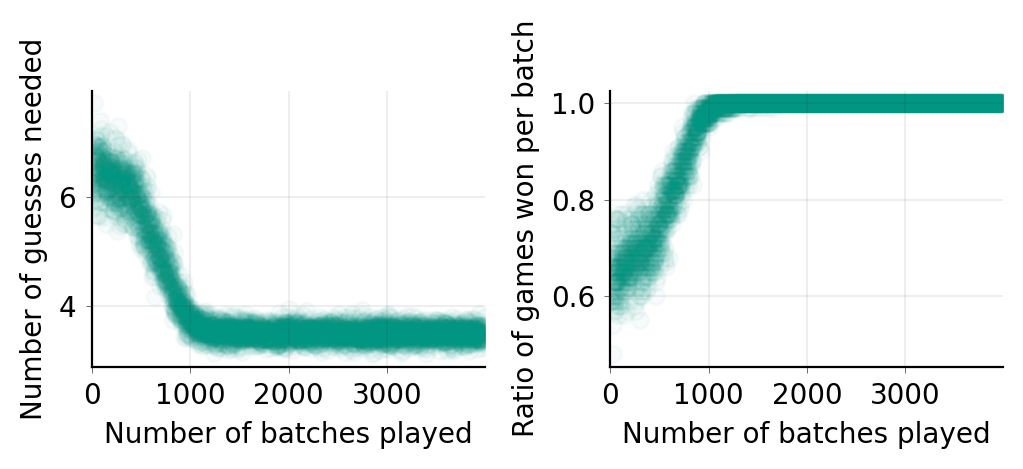

In [43]:
plt.style.use("kitishnotex")
fig,axs = plt.subplots(1,2)
axs[0].scatter(np.arange(nbatches),np.array(tries)/nrunsperbatch,alpha = 0.03)
axs[0].set_ylabel("Number of guesses needed")
axs[0].set_xlabel("Number of batches played")
axs[1].scatter(np.arange(nbatches),np.array(wins)/nrunsperbatch, alpha = 0.03)
axs[1].set_ylabel("Ratio of games won per batch")
axs[1].set_xlabel("Number of batches played");

We see that the machine dramaticallly improves over time and we are much better at guessing than initially. (Which is not difficult, given that we guessed randomly.) 
But what is the machine actually doing? Let's analyze some games.

In [44]:
nbatches = 1
nrunsperbatch = 10
_,_,_ = simulate(ncards,nbatches,nrunsperbatch,alpha,gamma,pi0,toprint=True)

 
The hidden number is:
3
Guesses: 
[0 5 3]
 
The hidden number is:
8
Guesses: 
[0 5 8]
 
The hidden number is:
4
Guesses: 
[0 5 3 4]
 
The hidden number is:
6
Guesses: 
[0 5 8 6]
 
The hidden number is:
1
Guesses: 
[0 5 3 1]
 
The hidden number is:
7
Guesses: 
[0 5 8 6 7]
 
The hidden number is:
3
Guesses: 
[0 5 3]
 
The hidden number is:
0
Guesses: 
[0]
 
The hidden number is:
5
Guesses: 
[0 5]
 
The hidden number is:
9
Guesses: 
[0 5 8 9]


It seems like the policy always starts by guessing $0$, then moves to $5$ if $0$ was too low, and then to $8$ or $3$. We can inspect this more clearly by looking at the policy.

Text(0.5, 1.0, 'If we guessed 0 (too low) and 5 (too low) and 8 (too high)')

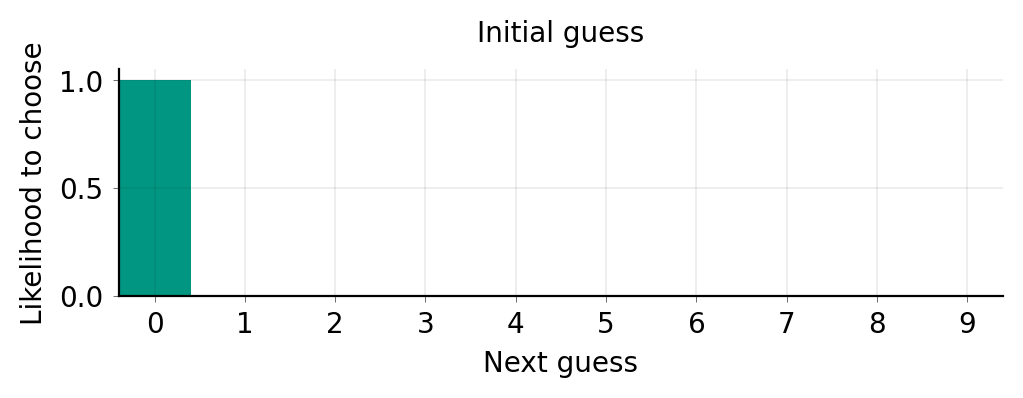

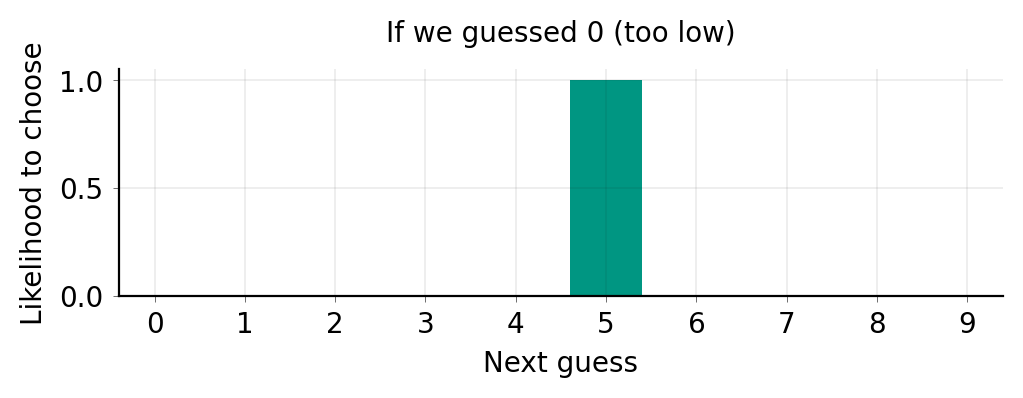

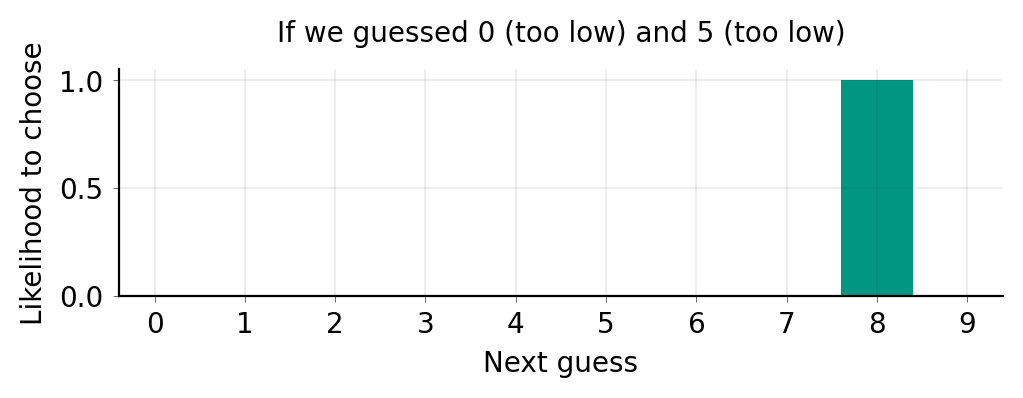

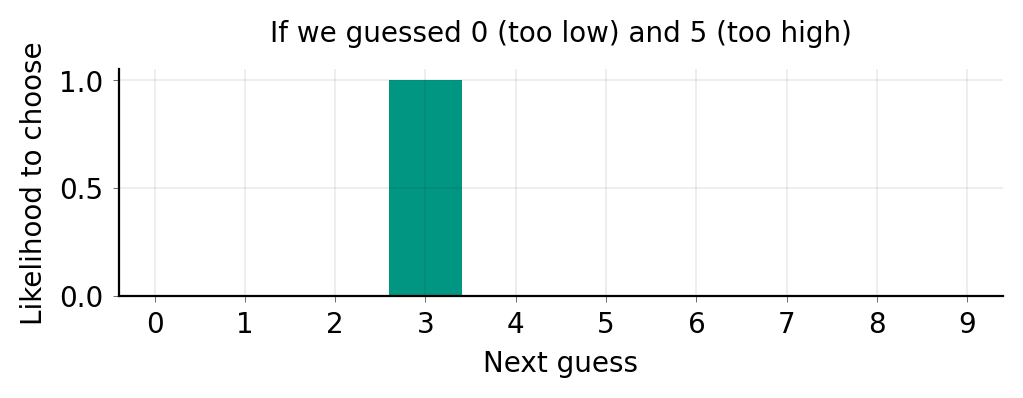

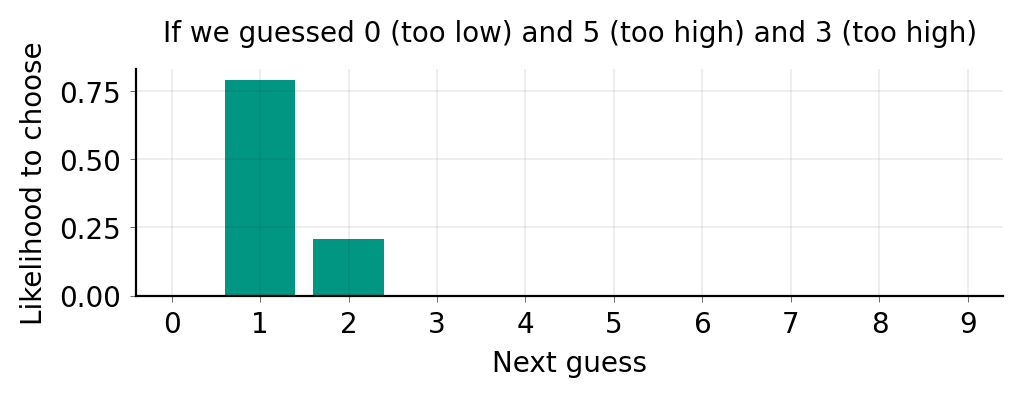

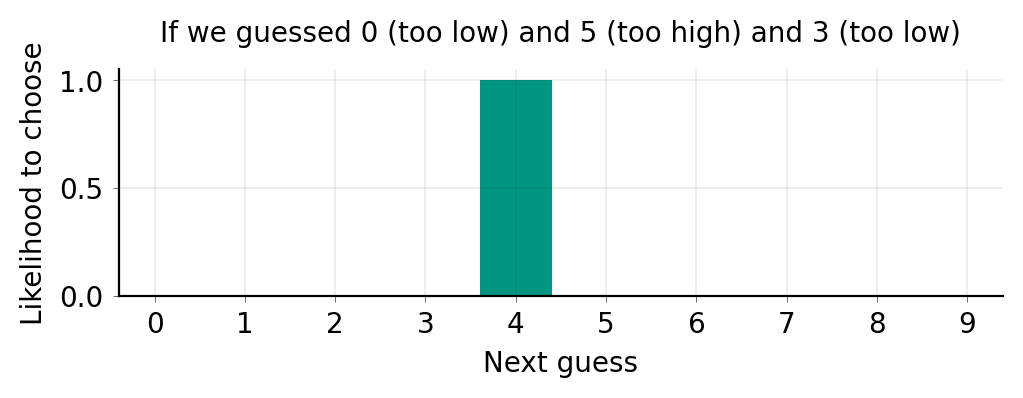

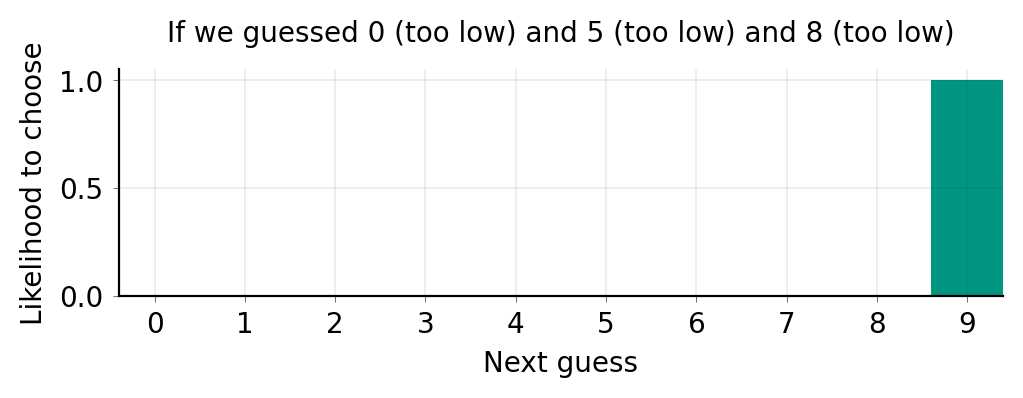

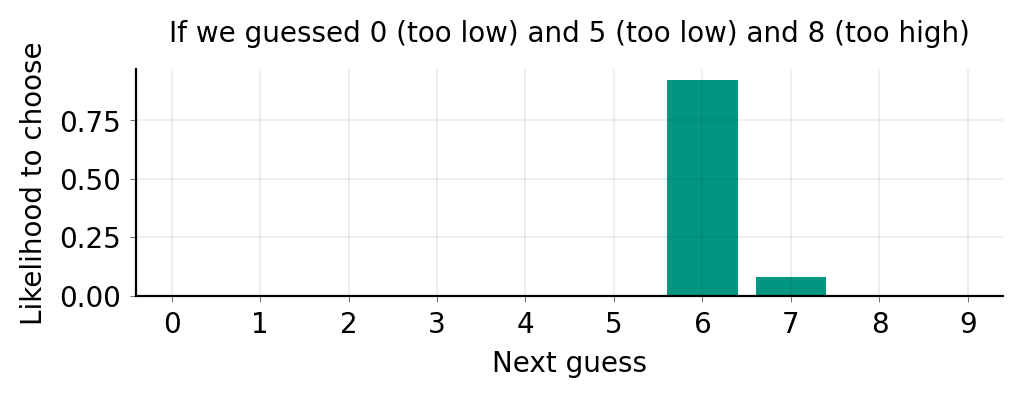

In [62]:
s = np.zeros(ncards,dtype=np.uint8)
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("Initial guess")

s[0] = LOW
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low)")


s[5] = LOW
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too low)")


s[5] = HIGH
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too high)")



s[3] = HIGH
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too high) and 3 (too high)")



s[3] = LOW
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too high) and 3 (too low)")




s[3] = UNKNOWN
s[5] = LOW 
s[8] = LOW
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too low) and 8 (too low)")


s[8] = HIGH
i = idx(s)
fig,ax = plt.subplots()
ax.bar(np.arange(ncards), pi[i,:])
ax.set_xticks(np.arange(ncards));
ax.set_xlabel("Next guess")
ax.set_ylabel("Likelihood to choose")
ax.set_title("If we guessed 0 (too low) and 5 (too low) and 8 (too high)")





This can be visualized more compactly as a searchtree
![tree](tree.jpg)

## Summary

The policy we learned is **not exactly** binary search. But after the initial guess $0$, we roughly split the numbers by half with $5$ as the next choice. From there, we again split the tree in half by choosing $3$ or $8$, depending on the outcome of guess $5$. Afterwards, $3$ different numbers remain in each case and the tree exectues the branch correctly. The fact that the probability to choose a $1$ vs $2$, or $6$ vs $7$ is not $100\%$ but smaller is not relevant, since both choices would be optimal. 

All in all I'm pleasently suprised with this first simple implementation. There was a bit of fine tuning necessary to get *good* values for $\alpha$ and $\gamma$, but not too much. 

The next question to address is the memory situation. For $10$ cards, it is easy to store the whole policy. For more cards, this might be problematic. One idea to overcome this, would be to only store policies that were triggered at least once. That way, we only need to keep track of significantly fewer policies (since we implicitely assume that and unknown state yields all numbers with equal probability).

More on that the next time. 